# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import json

Configuration

In [2]:
prop, level = 'ip', 'cp2k_blyp_dzvp'

## Gather outputs from runs
Get the configuration and test summary

In [3]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 10 completed runs


In [4]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'params.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    return output

In [5]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('mean_absolute_error')
summary.head()

,path,starting_model,atom_features,message_steps,output_layers,reduce_op,atomwise,num_epochs,batch_size,property,level,name,mean_absolute_error,r2_score,mean_squared_error
1,runs/f=128-T=4-r=mean-atomwise=False-hash=1a1e...,runs,128,4,"[64, 32, 32]",mean,False,512,32,ip,cp2k_blyp_dzvp_acn_adiabatic,oxidation_potential,0.262627,0.716314,0.206024
9,runs/f=128-T=4-r=sum-atomwise=True-hash=62df83b7,runs,128,4,"[64, 32, 32]",sum,True,512,32,ip,cp2k_blyp_dzvp_acn_adiabatic,oxidation_potential,0.268182,0.716730,0.205722
6,runs/f=256-T=4-r=mean-atomwise=False-hash=834d...,runs,256,4,"[64, 32, 32]",mean,False,512,32,ip,cp2k_blyp_dzvp_acn_adiabatic,oxidation_potential,0.270476,0.717775,0.204963
5,runs/f=128-T=4-r=mean-atomwise=False-hash=3d05...,runs,128,4,"[64, 32, 32]",mean,False,512,32,ip,cp2k_blyp_dzvp_acn_adiabatic,oxidation_potential,0.271081,0.698346,0.219073
4,runs/f=64-T=4-r=mean-atomwise=False-hash=5568bfaf,runs,64,4,"[64, 32, 32]",mean,False,512,32,ip,cp2k_blyp_dzvp_acn_adiabatic,oxidation_potential,0.273316,0.715889,0.206333


## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [6]:
to_eval = summary.query(f'property=="{prop}" and level=="{level}"')

In [7]:
best = summary.sort_values('mean_squared_error').iloc[0]
best

path                   runs/f=256-T=4-r=mean-atomwise=False-hash=834d...
starting_model                                                      runs
atom_features                                                        256
message_steps                                                          4
output_layers                                               [64, 32, 32]
reduce_op                                                           mean
atomwise                                                           False
num_epochs                                                           512
batch_size                                                            32
property                                                              ip
level                                       cp2k_blyp_dzvp_acn_adiabatic
name                                                 oxidation_potential
mean_absolute_error                                             0.270476
r2_score                                           

In [8]:
log = pd.read_csv(best.path / 'log.csv')

Text(0, 0.5, 'Loss')

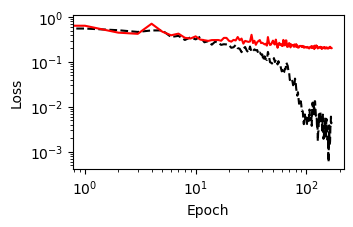

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.loglog(log.index, log['loss'], '--k')
ax.loglog(log.index, log['val_loss'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

Early stopping is working!

## Plot the predicted vs actual
See if there are significant outliers, etc

In [10]:
test_data = pd.read_csv(best.path / 'test_results.csv')
print(f'Loaded {len(test_data)} test records')

Loaded 839 test records


Text(0, 0.5, 'Actual')

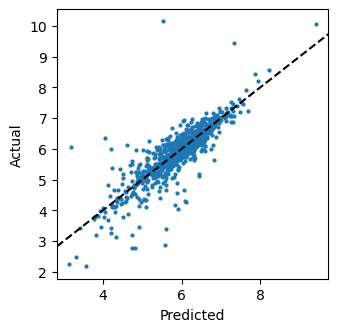

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['pred'], test_data['true'], s=4)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Save the top models
Get the path to the best model for each property, save a link to it

In [12]:
best_dir = Path("best_models")
if best_dir.is_dir():
    shutil.rmtree(best_dir)
best_dir

PosixPath('best_models')

In [13]:
for (prop, level), group in summary.groupby(['name', 'level']):
    (best_dir / prop).mkdir(exist_ok=True, parents=True)
    best = group.sort_values('mean_absolute_error', ascending=True).iloc[0]
    print(f'Best for {prop}/{level}: {best.path}')
    out_dir = best_dir / prop / level
    out_dir.symlink_to(best.path.absolute())

Best for oxidation_potential/cp2k_blyp_dzvp_acn_adiabatic: runs/f=128-T=4-r=mean-atomwise=False-hash=1a1e1558
